In [ ]:
import zipfile
from google.colab import drive
import os
import librosa
import librosa.display
import math
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Archive.zip", 'r')
# zip_ref = zipfile.ZipFile("/content/drive/My Drive/RAVDESSemotions1.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# take a look at our dataset
data = { 'Actor_ID': [],
         'Emotion': [],
         'Sentence': [],
         'Path': [] }

In [ ]:
def dataset_construction(condition, emotion):
  path = '/content/' + condition + "/" + emotion + '/'
  audios = os.listdir(path)
  for audio in audios:
    if audio == '.DS_Store':
      continue

    # actor_id
    data['Actor_ID'].append(audio[:2])

    # emotion
    data['Emotion'].append(emotion)

    # sentence
    sentence_number = audio[-6:-4]
    data['Sentence'].append(int(sentence_number))

    # path
    data['Path'].append(path + audio)

In [ ]:
X_train, Y_train = [], []
X_test, Y_test = [], []
X,Y = [],[]

def mfcc_extraction(condition, emotion, features_num = 29):
  path = '/content/' + condition + "/" + emotion + '/'
  audios = os.listdir(path)

  # features_num = 29

  mean_features = [] # mean for each audio
  emotion_labels = [] # emotions for each audio will be saved here

  for audio in audios:
    if audio == '.DS_Store':
      continue
    x, sr = librosa.load(path+audio, sr = 22050 * 2) # 22050 * 2 due to improving audio quality

    mean_mfccs = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=features_num).T,axis=0)
    mean_mfccs=np.append(mean_mfccs, np.diff(mean_mfccs))
    mean_mfccs=np.append(mean_mfccs, np.diff(np.diff(mean_mfccs)))
    mean_features.append(mean_mfccs)
    emotion_labels.append(emotion)


  return mean_features, emotion_labels

In [ ]:
def prepare_datasets(features_num = 29):
  conditions = ['Train', 'Test']
  emotions = ["Anger", "Disgust", "Fear", "Happiness", "Neutral", "Sadness", "Surprise"] #SAVEE

  for condition in conditions:
    for emotion in emotions:
      mean_features, emotion_labels = mfcc_extraction(condition, emotion)
      dataset_construction(condition, emotion)
      X.extend(mean_features)
      Y.extend(emotion_labels)

In [ ]:
prepare_datasets()

In [ ]:
df = pd.DataFrame(data)
df

,Actor_ID,Emotion,Sentence,Path
0,KL,Anger,12,/content/Train/Anger/KLa12.wav
1,JE,Anger,5,/content/Train/Anger/JEa05.wav
2,JK,Anger,5,/content/Train/Anger/JKa05.wav
3,DC,Anger,7,/content/Train/Anger/DCa07.wav
4,KL,Anger,13,/content/Train/Anger/KLa13.wav
...,...,...,...,...
475,JK,Surprise,3,/content/Test/Surprise/JKsu03.wav
476,KL,Surprise,4,/content/Test/Surprise/KLsu04.wav
477,KL,Surprise,1,/content/Test/Surprise/KLsu01.wav
478,KL,Surprise,3,/content/Test/Surprise/KLsu03.wav


In [ ]:
def find_eigen(A, iterations):
    mu, sigma = 0, 1
    x = np.random.normal(mu, sigma, size=A.shape[1])
    B = A.T.dot(A)
    for i in range(iterations):
        new_x = B.dot(x)
        x = new_x
    v = x / np.linalg.norm(x)
    sigma = np.linalg.norm(A.dot(v))
    u = A.dot(v) / sigma
    return np.reshape(
        u, (A.shape[0], 1)), sigma, np.reshape(
        v, (A.shape[1], 1))

In [ ]:
def power_svd(A):
  rank = np.linalg.matrix_rank(A)

  U = np.zeros((A.shape[0], 1))
  S = []
  V = np.zeros((A.shape[1], 1))

  iterations = 15

  # SVD using Power Method
  for i in range(rank):
    u, sigma, v = find_eigen(A, iterations)
    U = np.hstack((U, u))
    S.append(sigma)
    V = np.hstack((V, v))
    A = A - u.dot(v.T).dot(sigma)
  return  U[:, 1:], S, V[:, 1:].T

In [ ]:
def reduced_svd(A):
  '''
  Input: any matrix A
  Returns: tuple of matrix U, array of singular values and matrix V.T
  '''
  r = np.linalg.matrix_rank(A)

  AtA = np.dot(A.T, A)
  eigenvaluesV, eigenvectorsV = np.linalg.eig(AtA)

  idxs = np.argsort(eigenvaluesV)[::-1]
  V = np.array([ev[0:r] for ev in eigenvectorsV[:,idxs]])
  eigenvaluesV=(np.sort(eigenvaluesV)[0:r])[::-1]

  singular_values = np.sqrt(abs(eigenvaluesV))
  norms = np.array([1/sv for sv in singular_values])

  U = np.dot(A, np.dot(V, np.diag(norms)))
  # print("U -> \n", U, "\nD -> \n", singular_values, "\nV -> \n", V.T)
  return U, singular_values, V.T

In [ ]:
clf = SVC(kernel='linear', C=0.1, decision_function_shape='ovo', break_ties=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
U, D, V = reduced_svd(np.array(X_train))
k = 20

U_train = np.dot(U[:,:k], np.diag(D[:k]))
clf.fit(U_train, Y_train)

# X_test_coords = np.dot(X_test, np.dot(V[:k,:].T, np.diag(np.array([1/sv for sv in D[:k]]))))
X_test_coords = np.dot(X_test, V[:k,:].T)

Y_pred = clf.predict(X_test_coords)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", round(accuracy, 3))

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, Y_pred, average='weighted')
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1-score:", round(f1_score, 3))
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.667
Precision: 0.669
Recall: 0.667
F1-score: 0.663
Confusion Matrix:
[[ 9  0  1  1  0  0  0]
 [ 2 12  0  0  0  1  1]
 [ 0  0  6  2  0  0  1]
 [ 0  0  1  7  0  0  2]
 [ 1  2  1  0 16  3  0]
 [ 0  1  0  1  6  3  0]
 [ 0  0  4  1  0  0 11]]


Accuracy: 0.667
Precision: 0.669
Recall: 0.667
F1-score: 0.663
Confusion Matrix:


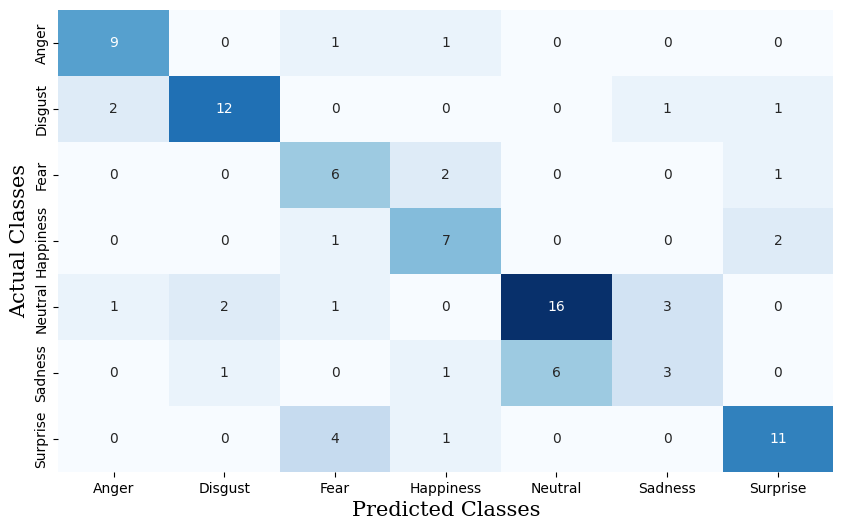

In [ ]:
clf_p = SVC(kernel='linear', C=0.1, decision_function_shape='ovo', break_ties=False)
Up, Dp, Vp = power_svd(np.array(X_train))

U_train_p = np.dot(Up[:,:k], np.diag(Dp[:k]))

clf_p.fit(U_train_p, Y_train)

# X_test_p = np.dot(X_test, np.dot(Vp[:k,:].T, np.diag(np.array([1/sv for sv in Dp[:k]]))))
X_test_p_coords = np.dot(X_test, Vp[:k,:].T)

Y_pred_p = clf_p.predict(X_test_p_coords)
print("Accuracy:", round(accuracy_score(Y_test,Y_pred_p), 3))

precision_p, recall_p, f1_score_p, _ = precision_recall_fscore_support(Y_test, Y_pred_p, average='weighted')
print("Precision:", round(precision_p, 3))
print("Recall:", round(recall_p, 3))
print("F1-score:", round(f1_score_p, 3))
conf_matrix = confusion_matrix(Y_test, Y_pred_p)
print("Confusion Matrix:")
plt.figure(figsize=[10,6])
sns.heatmap(conf_matrix, cmap='Blues', cbar=False, annot=True)
plt.xticks(np.arange(7)+0.5,clf.classes_)
plt.yticks(np.arange(7)+0.5,clf.classes_)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 15,
        }
plt.xlabel("Predicted Classes", fontdict=font)
plt.ylabel("Actual Classes",fontdict=font)
plt.show()

In [ ]:
k_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]
accuracies = []
accuracies_p = []

for k1 in k_values:
  clf = SVC(kernel='linear', C=0.1, decision_function_shape='ovo', break_ties=False)
  U_train = np.dot(U[:,:k1], np.diag(D[:k1]))
  clf.fit(U_train, Y_train)
  X_test_coords = np.dot(X_test, V[:k1,:].T)
  Y_pred = clf.predict(X_test_coords)
  accuracy = accuracy_score(Y_test, Y_pred)
  accuracies.append(accuracy)

  clf_p = SVC(kernel='linear', C=0.1, decision_function_shape='ovo', break_ties=False)
  Up_train = np.dot(Up[:,:k1], np.diag(Dp[:k1]))
  clf_p.fit(Up_train, Y_train)
  X_test_p_coords = np.dot(X_test, Vp[:k1,:].T)
  Y_pred_p = clf_p.predict(X_test_p_coords)
  accuracy_p = accuracy_score(Y_test, Y_pred_p)
  accuracies_p.append(accuracy_p)


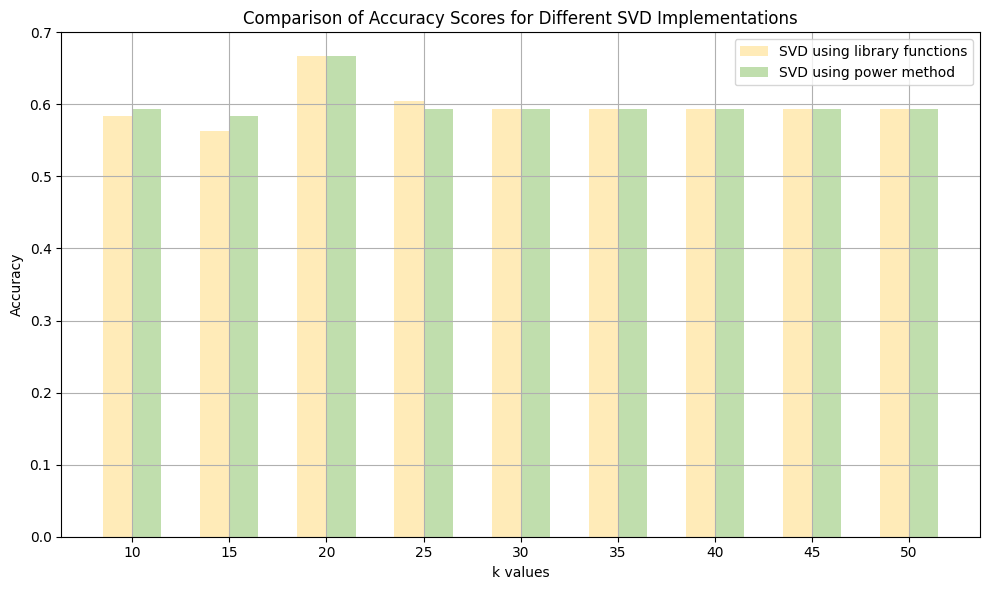

In [ ]:
data1 = []

for k1, accuracy, accuracy_p in zip(k_values, accuracies, accuracies_p):
    data1.append({'k': k1, 'accuracy_eigen': accuracy, 'accuracy_manually': accuracy_p})

df = pd.DataFrame(data1)

plt.figure(figsize=(10, 6))

bar_width = 1.5
index = df['k']

plt.bar(index - bar_width/2, df['accuracy_eigen'], bar_width, label='SVD using library functions', color = "#FFEBB8")
plt.bar(index + bar_width/2, df['accuracy_manually'], bar_width, label='SVD using power method', color = "#C0DEAD")

plt.title('Comparison of Accuracy Scores for Different SVD Implementations')
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(index, k_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()